<a href="https://colab.research.google.com/github/niti2111/Image-Noise-Prediction-Noise-reduction-Techniques/blob/main/INPPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python scikit-image
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Noise addition functions
def add_gaussian_noise(image, intensity):
    """Add Gaussian noise to an image"""
    row, col, ch = image.shape
    mean = 0
    var = 0.1 * intensity
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss
    return np.clip(noisy_image, 0, 255)

def add_poisson_noise(image, intensity):
    """Add Poisson noise to an image"""
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals) * intensity
    return np.clip(noisy_image, 0, 255)

def add_speckle_noise(image, intensity):
    """Add Speckle noise to an image"""
    row, col, ch = image.shape
    gauss = np.random.randn(row, col, ch)
    noisy_image = image + image * gauss * intensity
    return np.clip(noisy_image, 0, 255)

def add_shot_noise(image, intensity):
    """Add Shot noise to an image"""
    noisy_image = np.copy(image)
    num_shots = int(np.ceil(intensity * image.size))  # Cast to int
    coords = [np.random.randint(0, i - 1, num_shots) for i in image.shape[:2]]  # Random coordinates for shot noise
    noisy_image[coords[0], coords[1], :] = np.random.randint(0, 255, size=(num_shots, 3))  # Random shot pixels in RGB
    return noisy_image


def add_quantization_noise(image, intensity):
    """Add Quantization noise to an image"""
    levels = int(255 // intensity)
    noisy_image = (image // levels) * levels
    return np.clip(noisy_image, 0, 255)

# Function to apply noise to images
def apply_noise(image, noise_type, intensity):
    if noise_type == 'gaussian':
        return add_gaussian_noise(image, intensity)
    elif noise_type == 'poisson':
        return add_poisson_noise(image, intensity)
    elif noise_type == 'speckle':
        return add_speckle_noise(image, intensity)
    elif noise_type == 'shot':
        return add_shot_noise(image, intensity)
    elif noise_type == 'quantization':
        return add_quantization_noise(image, intensity)

# Noise types and intensity levels
noise_types = ['gaussian', 'poisson', 'speckle', 'shot', 'quantization']
intensity_levels = ['low', 'mild', 'high']
intensity_map = {'low': 1, 'mild': 2, 'high': 3}

# Directories
output_dir = '/content/drive/MyDrive/noisy_image_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# CSV to store image names and their respective noise types and intensities
csv_data = []

# Load your original dataset
image_dir = '/content/drive/MyDrive/Image'
image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Train-Validation-Test split (80%-10%-10%)
train_files, test_files = train_test_split(image_filenames, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# Helper function to save images with different noise levels
def save_noisy_images(image_files, output_subdir):
    for image_file in tqdm(image_files):
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        for noise_type in noise_types:
            for intensity_label in intensity_levels:
                intensity = intensity_map[intensity_label]
                noisy_image = apply_noise(image, noise_type, intensity)
                noisy_image_name = f"{os.path.splitext(image_file)[0]}_{noise_type}_{intensity_label}.png"
                noisy_image_path = os.path.join(output_subdir, noisy_image_name)

                cv2.imwrite(noisy_image_path, noisy_image)
                csv_data.append([noisy_image_name, noise_type, intensity_label])

# Save train, validation, and test noisy images
save_noisy_images(train_files, train_dir)
save_noisy_images(val_files, val_dir)
save_noisy_images(test_files, test_dir)

# Create CSV file
csv_df = pd.DataFrame(csv_data, columns=['image_name', 'noise_type', 'intensity_level'])
csv_df.to_csv(os.path.join(output_dir, 'noisy_image_labels.csv'), index=False)

print("Dataset creation complete!")


100%|██████████| 111/111 [00:22<00:00,  5.02it/s]


Dataset creation complete!


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the CSV file
csv_file = '/content/drive/MyDrive/noisy_image_dataset/noisy_image_labels.csv'
data = pd.read_csv(csv_file)

# Add a 'split' column to the DataFrame
# Create a list to store the split values
split = []
# Get the total number of samples
num_samples = len(data)
# Calculate the indices for the splits
train_split = int(0.8 * num_samples)
val_split = int(0.1 * num_samples)
# Assign split values based on indices
for i in range(num_samples):
  if i < train_split:
    split.append('train')
  elif i < train_split + val_split:
    split.append('val')
  else:
    split.append('test')

# Add the split list as a new column to the DataFrame
data['split'] = split

# Check the data structure
print(data.head())  # This will help you verify the column names and data

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom in/out
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Fill in any new pixels with nearest pixel values
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Create Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data[data['split'] == 'train'],  # Filter for training data
    x_col='image_name',
    y_col='noise_type',
    directory='/content/drive/MyDrive/noisy_image_dataset/train',  # Path to training images
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=data[data['split'] == 'val'],  # Filter for validation data
    x_col='image_name',
    y_col='noise_type',
    directory='/content/drive/MyDrive/noisy_image_dataset/validation',  # Path to validation images
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

print(f"Training classes: {train_generator.class_indices}")
print(f"Validation classes: {val_generator.class_indices}")

              image_name noise_type intensity_level  split
0   105_gaussian_low.png   gaussian             low  train
1  105_gaussian_mild.png   gaussian            mild  train
2  105_gaussian_high.png   gaussian            high  train
3    105_poisson_low.png    poisson             low  train
4   105_poisson_mild.png    poisson            mild  train
Found 13245 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Found 1647 validated image filenames belonging to 5 classes.
Training classes: {'gaussian': 0, 'poisson': 1, 'quantization': 2, 'shot': 3, 'speckle': 4}
Validation classes: {'gaussian': 0, 'poisson': 1, 'quantization': 2, 'shot': 3, 'speckle': 4}


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 9 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D # Added the import for GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Building the CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 classes for noise types

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,820,037 (6.94 MB)

 Trainable params: 1,818,117 (6.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Adjust the learning rate if necessary
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Callbacks for saving the best model and early stopping
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_noise_model.keras',  # Save best model
                                        monitor='val_accuracy',
                                        save_best_only=True,
                                        mode='max',
                                        verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # Stop training if no improvement
                                      patience=5,
                                      mode='max',
                                      verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Adjust epochs based on performance
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8422 - loss: 0.3901
Epoch 1: val_accuracy improved from -inf to 0.59563, saving model to best_noise_model.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 149s 328ms/step - accuracy: 0.8423 - loss: 0.3899 - val_accuracy: 0.5956 - val_loss: 0.9156
Epoch 2/20
413/414 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9043 - loss: 0.2187
Epoch 2: val_accuracy improved from 0.59563 to 0.71099, saving model to best_noise_model.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 128s 304ms/step - accuracy: 0.9043 - loss: 0.2187 - val_accuracy: 0.7110 - val_loss: 4.0690
Epoch 3/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9102 - loss: 0.2027
Epoch 3: val_accuracy improved from 0.71099 to 0.71767, saving model to best_noise_model.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 142s 305ms/step - accuracy: 0.9102 - loss: 0.2027 - val_accuracy: 0.7177 - val_loss: 4.3486
Epoch 4/20
413/414 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9230 - loss: 0.1862
Epoch 4: val_a

In [ ]:
model_save_path = '/content/drive/MyDrive/Model/Image_Noise_Prediction_model.h5'  # For saving as .h5 format
model.save(model_save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the Keras file
loaded_model = load_model('/content/drive/MyDrive/Model/Image_Noise_Prediction_model.h5')

# Verify that the model is loaded correctly
loaded_model.summary()  # Optional: Print model summary to check


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,820,039 (6.94 MB)

 Trainable params: 1,818,117 (6.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7155 - loss: 8.9009
Validation Loss: 9.6076
Validation Accuracy: 0.7007


NameError: name 'history' is not defined

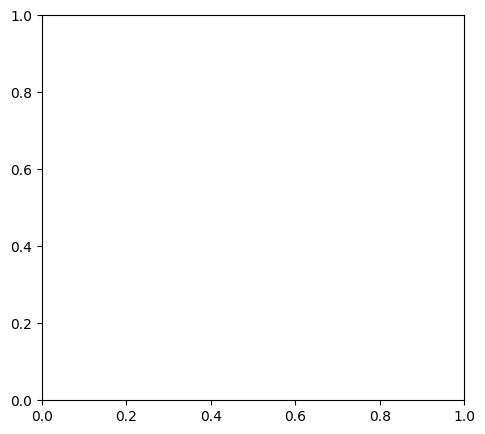

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model.fit()
# Replace 'history' with the variable name you used for the training history

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


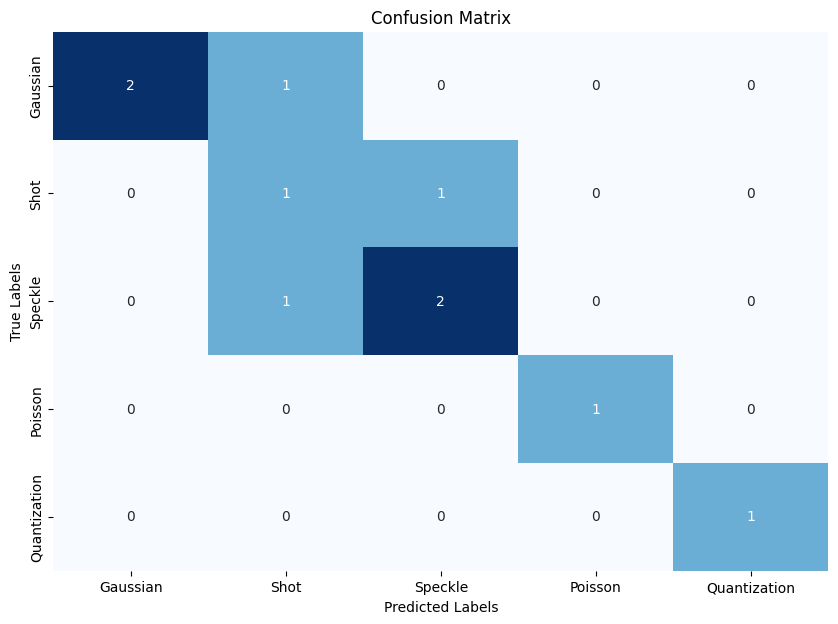

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example data (replace this with actual labels and predictions)
# For demonstration purposes, these are sample true and predicted labels.
true_labels = [0, 1, 2, 2, 1, 0, 0, 3, 4, 2]  # True class labels
predicted_labels = [0, 2, 2, 2, 1, 0, 1, 3, 4, 1]  # Predicted class labels

# Noise types for the confusion matrix
class_names = ['Gaussian', 'Shot', 'Speckle', 'Poisson', 'Quantization']

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Example image path
img_path = '/content/drive/MyDrive/noisy_image_dataset/test/00_005_speckle_low.png'  # Change this to your image path
img_array = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability

# Adjusted class mapping
class_mapping = {
    0: 'Gaussian',
    1: 'Poisson',
    2: 'Quantization',
    3: 'Shot',
    4: 'Speckle'
}

# Map the predicted class index to the noise type
predicted_noise_type = class_mapping.get(predicted_class[0], 'Unknown')

# Get the probabilities
predicted_probabilities = predictions[0]

# Print the results
print(f"Predicted noise type: {predicted_noise_type}")
print("Probabilities for each noise type:")
for idx, noise_type in class_mapping.items():
    print(f"{noise_type}: {predicted_probabilities[idx]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted noise type: Speckle
Probabilities for each noise type:
Gaussian: 0.0000
Poisson: 0.0000
Quantization: 0.0000
Shot: 0.0000
Speckle: 1.0000


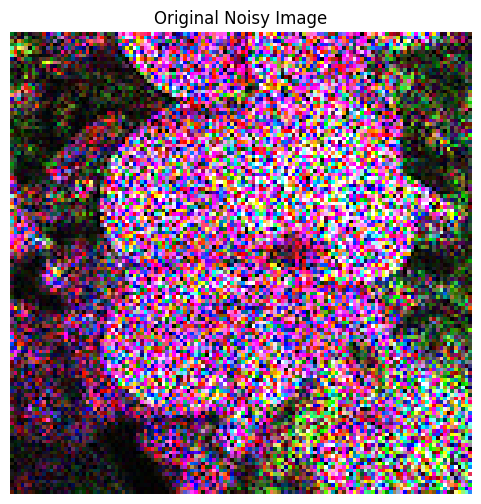

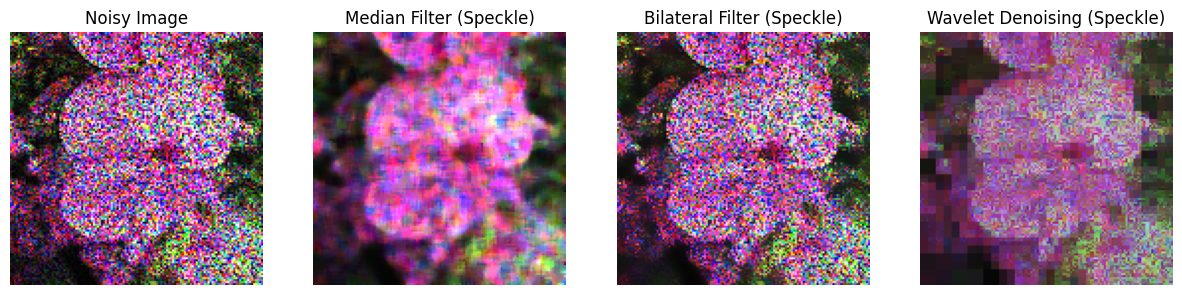

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration

def apply_filters(image, noise_type):
    filtered_images = {}

    # Add the noisy image to the dictionary
    filtered_images['Noisy Image'] = image

    # Apply filters based on the predicted noise type
    if noise_type == 'Gaussian':
        filtered_images['Gaussian Filter'] = cv2.GaussianBlur(image, (5, 5), 0)
        filtered_images['Median Filter (Gaussian)'] = cv2.medianBlur(image, 5)
        filtered_images['Bilateral Filter (Gaussian)'] = cv2.bilateralFilter(image, 9, 75, 75)

    elif noise_type == 'Shot':
        filtered_images['Gaussian Filter (Shot)'] = cv2.GaussianBlur(image, (5, 5), 0)
        filtered_images['Median Filter (Shot)'] = cv2.medianBlur(image, 5)
        filtered_images['Non-Local Means (Shot)'] = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    elif noise_type == 'Speckle':
        filtered_images['Median Filter (Speckle)'] = cv2.medianBlur(image, 5)
        filtered_images['Bilateral Filter (Speckle)'] = cv2.bilateralFilter(image, 9, 75, 75)
        filtered_images['Wavelet Denoising (Speckle)'] = restoration.denoise_wavelet(image, channel_axis=-1)

    elif noise_type == 'Quantization':
        filtered_images['Median Filter (Quantization)'] = cv2.medianBlur(image, 5)
        filtered_images['Bilateral Filter (Quantization)'] = cv2.bilateralFilter(image, 9, 75, 75)
        filtered_images['Gaussian Filter (Quantization)'] = cv2.GaussianBlur(image, (5, 5), 0)

    elif noise_type == 'Poisson':
        filtered_images['Median Filter (Poisson)'] = cv2.medianBlur(image, 5)
        filtered_images['Non-Local Means (Poisson)'] = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        filtered_images['Wavelet Denoising (Poisson)'] = restoration.denoise_wavelet(image, channel_axis=-1)

    return filtered_images

def display_filtered_images(filtered_images):
    num_images = len(filtered_images)
    num_rows = (num_images + 3) // 4  # Round up to the nearest multiple of 4

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure height based on number of rows
    for i, (title, img) in enumerate(filtered_images.items()):
        plt.subplot(num_rows, 4, i + 1)  # Create subplot grid with enough rows
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Load an example image with noise
image_path = '/content/drive/MyDrive/noisy_image_dataset/test/00_005_speckle_low.png'  # Change this to your image path
image_with_noise = cv2.imread(image_path)

# Check if the image was loaded successfully
if image_with_noise is None:
    print("Error: Image not found or unable to load.")
else:
    image_with_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_BGR2RGB)

    # Display the noisy image before applying filters
    plt.figure(figsize=(6, 6))
    plt.imshow(image_with_noise)
    plt.title('Original Noisy Image')
    plt.axis('off')
    plt.show()

    # Model prediction; change this to the predicted noise type
    predicted_noise_type = 'Speckle'  # Replace this with actual prediction from your model

    # Apply filters based on predicted noise type
    filtered_images = apply_filters(image_with_noise, predicted_noise_type)

    # Display the original noisy image and filtered images
    display_filtered_images(filtered_images)
